In [1]:
import numpy as np
from scipy import stats
from ase import io

import matplotlib.pyplot as plt

In [2]:
from intdielec.calculator.elecpot import ElecPotentialCalculator
from intdielec.utils.unit import *

In [9]:
def water_rho(atoms, binsize=0.01):
    """
    Return charge density in e/A^3
    """
    q_O = -0.820
    q_H = 0.410
    # define the edges of bins
    bins = np.arange(0., atoms.cell[2][2]+binsize, binsize)
    # n_bins = len(bins) - 1
    cross_area = np.linalg.norm(np.cross(atoms.cell[0], atoms.cell[1]))
    # print(cross_area)
    
    z = atoms.get_positions()[:, 2]
    atype = np.array(atoms.get_chemical_symbols())
    O_ids = np.nonzero(atype == "O")
    H_ids = np.nonzero(atype == "H")
    
    x = np.concatenate([z[O_ids], z[H_ids]])
    y = np.concatenate([np.full_like(z[O_ids], q_O), np.full_like(z[H_ids], q_H)])
    _data, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='sum', bins=bins)
    data = _data / (cross_area * binsize) 

    dipole = np.sum(q_O * z[O_ids]) + np.sum(q_H * z[H_ids])
    # e/A^2
    surf_pol = dipole / cross_area
    return (bin_edges[1:] + bin_edges[:-1]) / 2., data, surf_pol 

def water_potential(atoms, binsize=0.01):
    _EPSILON = VAC_PERMITTIVITY / UNIT_CHARGE * ANG_TO_M
    x, rho, surf_pol = water_rho(atoms, binsize)
    task = ElecPotentialCalculator(charge=rho, grid=x)
    phi = task.calculate()
    phi_cor = phi + surf_pol / _EPSILON * (x / atoms.cell[2][2] - 0.5)
    return (x, rho, phi, phi_cor)

In [10]:
atoms = io.read("data/coord.xyz")
out = water_potential(atoms)

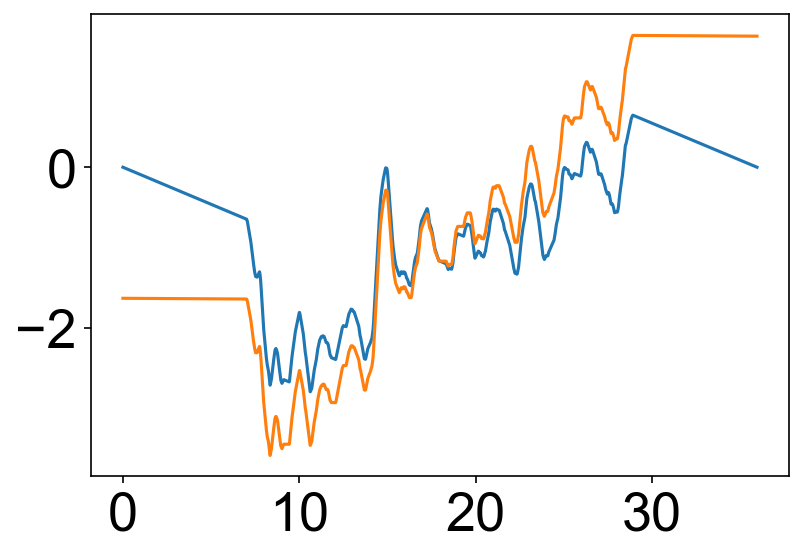

In [11]:
# plt.plot(out[0], out[1])
plt.plot(out[0], out[2])
plt.plot(out[0], out[3])

plt.show()

---

In [6]:
def water_rho(atoms, binsize=0.01):
    """
    Return charge density in e/A^3
    """
    q_O = -0.820
    q_H = 0.410
    # define the edges of bins
    bins = np.arange(0., atoms.cell[2][2]+binsize, binsize)
    # n_bins = len(bins) - 1
    cross_area = np.linalg.norm(np.cross(atoms.cell[0], atoms.cell[1]))
    # print(cross_area)
    
    z = atoms.get_positions()[:, 2]
    atype = np.array(atoms.get_chemical_symbols())
    O_ids = np.nonzero(atype == "O")
    H_ids = np.nonzero(atype == "H")
    
    x = np.concatenate([z[O_ids], z[H_ids]])
    y = np.concatenate([np.full_like(z[O_ids], q_O), np.full_like(z[H_ids], q_H)])
    _data, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='sum', bins=bins)
    data = _data / (cross_area * binsize) 

    return (bin_edges[1:] + bin_edges[:-1]) / 2., data

In [4]:
atoms = io.read("data/coord.xyz")
x, rho = water_rho(atoms)

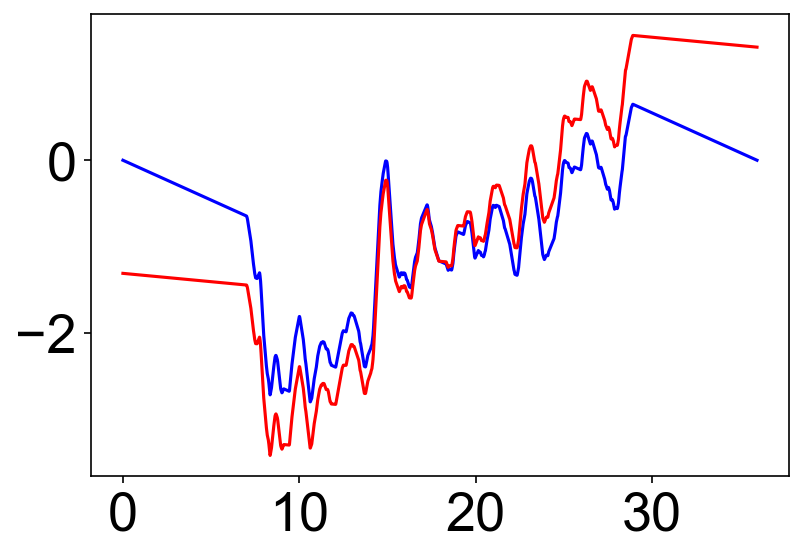

In [7]:
task = ElecPotentialCalculator(charge=rho, grid=x)

plt.plot(x, task.calculate(), color="blue")
plt.plot(x, task.calculate(bc="dip_cor", cell=atoms.get_cell()), color="red")

plt.show()